In [1]:
import sys
import os
import getpass

# Path to where your CaloQVAE dir is
upper_dir = 'WLVAE'
# Path to where your CaloQVAE dir is
os.chdir('/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}' + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + f'/{upper_dir}/')

#external libraries
import os

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())

In [2]:
xgen_samples = torch.load('/home/' + getpass.getuser() +'/samples/xgen_samples.pt')
xrecon_samples = torch.load('/home/' + getpass.getuser() + '/samples/xrecon_samples.pt')
xtarget_samples = torch.load('/home/' + getpass.getuser() + '/samples/xtarget_samples.pt')
entarget_samples = torch.load('/home/' + getpass.getuser() + '/samples/entarget_samples.pt')

In [3]:
def measure_single_granularity(data_tensor_1, index):
    """
    Measure the granularity of a calorimeter image given as a 1D array using PyTorch.
    
    Parameters:
    data (array-like): 1D array representing the calorimeter image.
    
    Returns:
    float: A measure of the granularity.
    """
    # Calculate the differences between consecutive elements
#     diffs_1 = (data_tensor_1[:,index:] - data_tensor_1[:,:-index])/torch.mean(data_tensor_1[:,:-index], dim = 1, keepdim=True)
    diffs_1 = (data_tensor_1[:,index:] - data_tensor_1[:,:-index])
#     std_g = torch.std(diffs_1, dim = 1)
    return diffs_1


def measure_stochastic_granularity(data_tensor):
    segment_length = 144  # Length of each segment
    num_segments = 45     # Number of segments per sample
    num_samples = data_tensor.size(0)  # Number of samples in the data tensor

    # Use PyTorch to generate a random integer array of shape (num_samples,) with values between 0 and 15
    random_array = torch.randint(0, 16, (num_samples,), dtype=torch.int64, device=data_tensor.device)

    # Multiply random_array by 9 and expand it to shape (num_samples, num_segments)
    shifts = (random_array * 9).unsqueeze(-1).expand(-1, num_segments)

    # Unfold the data tensor to create segments of length 144
    # The result is a tensor of shape (num_samples, num_segments, segment_length)
    segments = data_tensor.unfold(1, segment_length, segment_length)

    # Create an indices tensor of shape (num_samples, num_segments, segment_length)
    indices = torch.arange(segment_length, device=data_tensor.device).repeat(num_samples, num_segments, 1)
    # Adjust the indices by adding the shifts and applying modulo operation to wrap around
    indices = (indices + shifts.unsqueeze(-1)) % segment_length  # Ensure correct broadcasting

    # Gather elements from the segments tensor using the adjusted indices
    rotated_segments = torch.gather(segments, 2, indices)

    # Reshape the rotated_segments tensor back to the original shape of data_tensor
    result_tensor = rotated_segments.view(num_samples, -1)

    # Compute the difference between the original data tensor and the result tensor
    diffs = data_tensor - result_tensor

    return diffs                                    

In [4]:
# granularity_target = measure_single_granularity(xtarget_samples,9)
# # granularity_sample = measure_single_granularity(xgen_samples,9)
# granularity_recon = measure_single_granularity(xrecon_samples,9)

granularity_target = measure_stochastic_granularity(xtarget_samples)
# granularity_sample = measure_single_granularity(xgen_samples,9)
granularity_recon = measure_stochastic_granularity(xrecon_samples)

In [5]:
class Final_Dropout(nn.Module):
    def __init__(self, p=0.5, coe = 1):
        super().__init__()
        self.p = p  # 保留概率
        self.coe = coe
    def forward(self, x):
        low = 1
        high = 100
        # 生成整数噪声
        # integer_noise = torch.randint(low=low, high=high, size=x.size(), dtype=x.dtype, device=x.device)
        integer_noise = (torch.rand(x.size(), dtype=x.dtype, device=x.device) * 100).float()
        # 生成伯努利分布的掩码，1的概率为self.p
        mask = torch.bernoulli(torch.full_like(x, self.p, dtype=torch.float32))
        gaussian_noise = torch.randn_like(x)
        noise = integer_noise.float() * gaussian_noise * self.coe 
        masked_result = x + torch.sqrt(torch.abs(x)) * mask * noise
        rulu = nn.ReLU()
        masked_result = rulu(masked_result)
        return masked_result

In [6]:
# xrecon_samples_alt = Final_Dropout(p=0.5, coe = 0.149)(xrecon_samples)
# granularity_recon_alt = measure_stochastic_granularity(xrecon_samples_alt)

In [7]:
granularity_target.shape

torch.Size([10000, 6480])

In [8]:
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
# indices = range(1000, 10001, 1000)  # 从1000到9000，每隔1000

# for ax, i in zip(axes.flatten(), indices):
#     ax.plot(granularity_target[i], label='Target', alpha=0.5)
#     ax.plot(granularity_recon[i], label='Recon', alpha=0.5)
#     ax.plot(granularity_recon_alt[i], label='Alt', alpha=0.5)
#     total_energy = int((torch.sum(xtarget_samples[i])+torch.sum(xrecon_samples[i]))/2)
#     ax.set_xlabel('Voxel ID')
#     ax.set_ylabel('abs(Diffs)')
#     ax.legend()
#     ax.set_title(f'Granularity Map for Event {i} \n Input Energy = {total_energy} MeV')

# plt.tight_layout()
# plt.show()

In [9]:
# std_target = torch.std(granularity_target, dim =1)
# std_recon = torch.std(granularity_recon, dim =1)
# std_recon_alt = torch.std(granularity_recon_alt, dim =1)
# mean_std_target=torch.mean(std_target)
# mean_std_recon=torch.mean(std_recon)
# std_recon_alt_list = []
# std_target_list = []
# std_recon_list = []
# for i in range(20):
#     xrecon_samples_alt = Final_Dropout(p=0.5, coe = 0.01*i)(xrecon_samples)
#     granularity_recon_alt = measure_stochastic_granularity(xrecon_samples_alt)
#     std_recon_alt = torch.std(granularity_recon_alt, dim =1)
#     mean_std_recon_alt=torch.mean(std_recon_alt)
#     std_recon_alt_list.append(mean_std_recon_alt)
#     std_target_list.append(mean_std_target)
#     std_recon_list.append(mean_std_recon)

In [10]:
std_target = torch.std(granularity_target, dim =1)
coe = 0.0
lr = 0.001
loss_list = []
coe_list = []
for i in range(50):
    xrecon_samples_alt = Final_Dropout(p=0.5, coe = coe)(xrecon_samples)
    granularity_recon_alt = measure_stochastic_granularity(xrecon_samples_alt)
    std_recon_alt = torch.std(granularity_recon_alt, dim =1)
    mean_std_recon_alt=torch.mean(std_recon_alt)
    loss = torch.mean((std_target - std_recon_alt)**2)
    print(f'coe = {coe}, loss = {loss}')
    coe = abs(coe + lr * (std_target - std_recon_alt).mean())
    loss_list.append(loss)
    coe_list.append(coe)

coe = 0.0, loss = 774.394287109375
coe = 0.017701026052236557, loss = 701.7633666992188
coe = 0.03451346233487129, loss = 574.779296875
coe = 0.049549926072359085, loss = 465.7432556152344
coe = 0.06276649236679077, loss = 370.7016906738281
coe = 0.07422102987766266, loss = 308.1148681640625
coe = 0.08423628658056259, loss = 263.2966003417969
coe = 0.09291492402553558, loss = 227.6414794921875
coe = 0.1004081442952156, loss = 204.81170654296875
coe = 0.10707088559865952, loss = 183.16261291503906
coe = 0.11280015856027603, loss = 169.98216247558594
coe = 0.11772340536117554, loss = 158.49415588378906
coe = 0.12212376296520233, loss = 154.5045928955078
coe = 0.1259198784828186, loss = 151.19972229003906
coe = 0.12928803265094757, loss = 140.08152770996094
coe = 0.1320171356201172, loss = 147.73233032226562
coe = 0.13457918167114258, loss = 143.8772430419922
coe = 0.13677628338336945, loss = 140.93475341796875
coe = 0.1387471705675125, loss = 140.7384796142578
coe = 0.14042696356773376, 

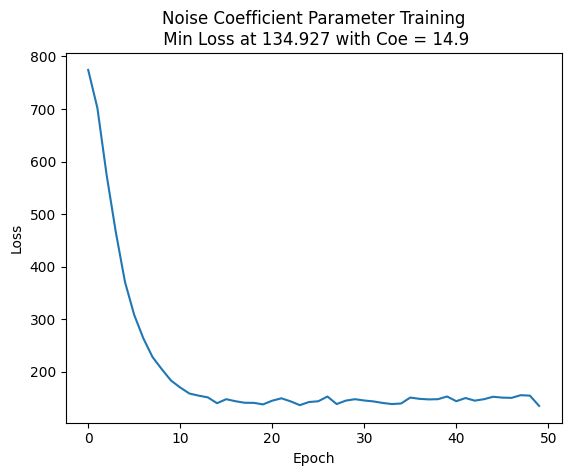

In [11]:
X = np.arange(0, 50, 1)
plt.plot(X, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 获取最小损失值并保留三位小数
min_loss = min(loss_list).item()
# 获取对应的系数并保留三位小数
min_coe = coe_list[loss_list.index(min(loss_list))].item()
rounded_min_loss = round(min_loss, 3)
rounded_min_coe = round(min_coe, 3)
plt.title(f'Noise Coefficient Parameter Training\n Min Loss at {rounded_min_loss} with Coe = 14.9')  
plt.show()


In [17]:
min_coe

0.15232230722904205

In [18]:
xrecon_samples_alt = Final_Dropout(p=0.5, coe = min_coe)(xrecon_samples)
std_target = torch.std(granularity_target, dim =1)
std_recon = torch.std(granularity_recon, dim =1)
std_recon_alt = torch.std(granularity_recon_alt, dim =1)

In [19]:
min_loss

134.92718505859375

In [20]:
# X = np.linspace(0, 0.2, 20)
# plt.plot(X,std_target_list, label='Target')
# plt.plot(X,std_recon_list, label='Recon')
# plt.plot(X,std_recon_alt_list, label='Alt')
# plt.ylabel('Granularity')
# plt.legend()
# plt.show()

In [21]:
# std_recon_alt_list

In [22]:
# std_target.shape

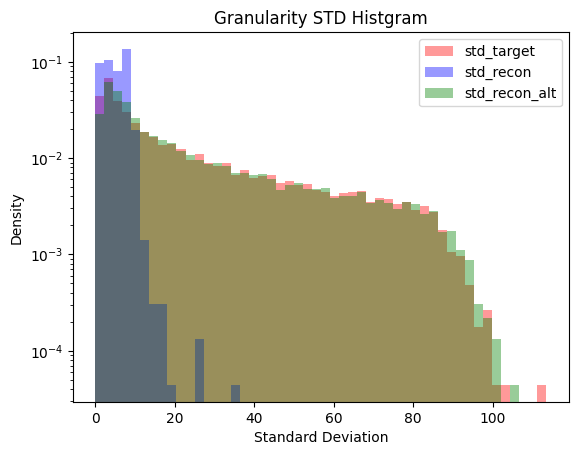

In [23]:
combined_data = np.concatenate((std_target, std_recon))
bins = np.histogram_bin_edges(combined_data, bins=50)
plt.hist(std_target, log=True, color = 'red', bins=bins,alpha = 0.4, label = "std_target", density = True)
plt.hist(std_recon, log=True, color = 'blue', alpha = 0.4, bins=bins, label = "std_recon", density = True)
plt.hist(std_recon_alt, log=True, color = 'green', alpha = 0.4, bins=bins, label = "std_recon_alt", density = True)
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.legend()
plt.title("Granularity STD Histgram")
plt.show()

In [24]:
index = []
error_target_list = []
error_recon_list = []
error_alt_list = []
ratio_list = []
ratio_list_alt = []
for i in range(1, 30):
    error_recon = torch.mean(torch.std(measure_single_granularity(xrecon_samples, i),dim=0))
    error_target = torch.mean(torch.std(measure_single_granularity(xtarget_samples, i),dim=0))
    error_alt = torch.mean(torch.std(measure_single_granularity(xrecon_samples_alt, i),dim=0))
    ratio = error_target/error_recon
    ratio_alt = error_target/error_alt
    error_recon_list.append(error_recon)
    error_target_list.append(error_target)
    error_alt_list.append(error_alt)
    ratio_list.append(ratio)
    ratio_list_alt.append(ratio_alt)
    index.append(i)

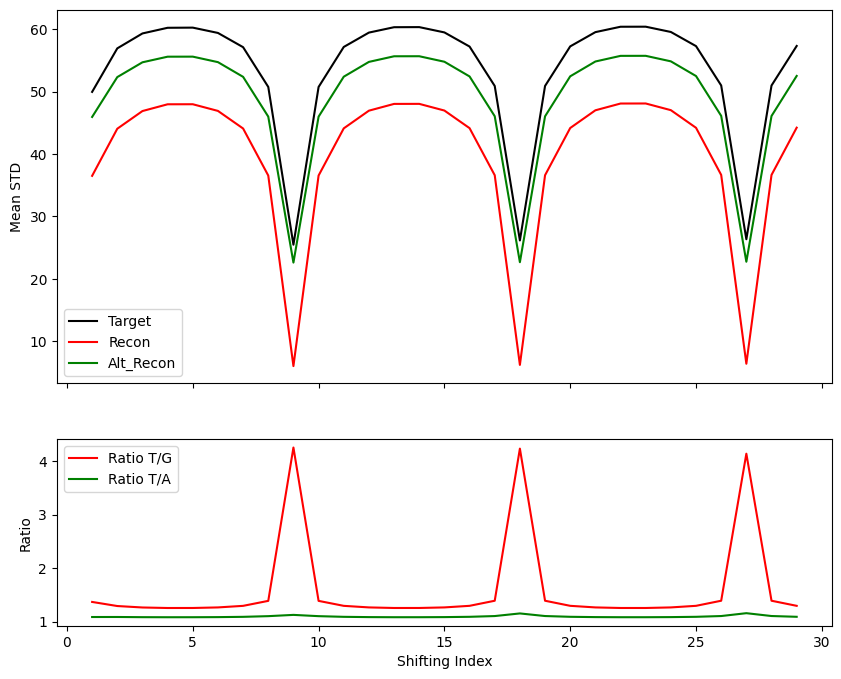

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

# 在第一个子图中绘制 error_gen_list 和 error_target_list
ax1.plot(index, error_target_list, label='Target', color='black')
ax1.plot(index, error_recon_list, label='Recon', color='red')
ax1.plot(index, error_alt_list, label='Alt_Recon', color='green')
ax1.legend()
ax1.set_ylabel('Mean STD')

# 在第二个子图中绘制 ratio_list
ax2.plot(index, ratio_list, label='Ratio T/G', color='red')
ax2.plot(index, ratio_list_alt, label='Ratio T/A', color='green')
ax2.legend()
ax2.set_xlabel('Shifting Index')
ax2.set_ylabel('Ratio')

plt.show()

In [26]:
# import time
# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144
#     num_segments = 45
#     rng = np.random.default_rng()
#     random_array = rng.integers(0, 16, size=num_segments)
#     result_tensor = torch.empty_like(data_tensor)
#     for row_idx in range(data_tensor.size(0)):  # 遍历每一行
#         row = data_tensor[row_idx]
#         segments = []
#         for i in range(num_segments):
#             segment = row[i*segment_length:(i+1)*segment_length]
#             rotated_segment = torch.roll(segment, shifts=random_array[i]*9)
#             segments.append(rotated_segment)

#         result_tensor[row_idx] = torch.cat(segments)

#     diffs = data_tensor - result_tensor
#     return diffs


# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144
#     num_segments = 45
#     rng = np.random.default_rng()
#     random_array = rng.integers(0, 16, size=num_segments)
#     print(random_array)
    
#     # 创建一个与data_tensor相同形状的tensor
#     result_tensor = torch.empty_like(data_tensor)
    
#     # 预先计算好所有需要的roll shifts
#     shifts = torch.tensor(random_array * 9)

#     # 将data_tensor按照segment_length进行分割
#     segments = data_tensor.unfold(1, segment_length, segment_length)
    
#     # 创建一个空的tensor来存储所有旋转后的segments
#     rotated_segments = torch.empty_like(segments)
    
#     # 使用广播机制计算所有旋转后的segments
#     for i in range(num_segments):
#         rotated_segments[:, i, :] = torch.roll(segments[:, i, :], shifts=shifts[i].item(), dims=1)
    
#     # 将旋转后的segments重新拼接成完整的tensor
#     result_tensor = rotated_segments.reshape(data_tensor.size(0), -1)
    
#     # 计算差异
#     diffs = data_tensor - result_tensor
#     return diffs

# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144
#     num_segments = 45
#     num_samples = data_tensor.size(0)
    
#     rng = np.random.default_rng()
#     random_array = rng.integers(0, 16, size=(num_samples, num_segments))
#     print(random_array)
    
#     shifts = torch.tensor(random_array * 9, dtype=torch.int64)
    
#     segments = data_tensor.unfold(1, segment_length, segment_length)
    
#     indices = torch.arange(segment_length).repeat(num_samples, num_segments, 1)
#     indices = (indices + shifts.unsqueeze(-1)) % segment_length
    
#     rotated_segments = torch.gather(segments, 2, indices)

#     result_tensor = rotated_segments.view(num_samples, -1)
    
#     diffs = data_tensor - result_tensor
#     return diffs

# def measure_stochastic_granularity(data_tensor):
#     segment_length = 144  # Length of each segment
#     num_segments = 45     # Number of segments per sample
#     num_samples = data_tensor.size(0)  # Number of samples in the data tensor
    
#     # Create a random number generator
#     rng = np.random.default_rng()
#     # Generate a random integer array of shape (num_samples, num_segments) with values between 0 and 15
#     random_array = rng.integers(0, 16, size=(num_samples, num_segments))
#     print(random_array)
    
#     # Multiply random_array by 9 and convert to a PyTorch tensor of type int64
#     shifts = torch.tensor(random_array * 9, dtype=torch.int64)
    
#     # Unfold the data tensor to create segments of length 144
#     # The result is a tensor of shape (num_samples, num_segments, segment_length)
#     segments = data_tensor.unfold(1, segment_length, segment_length)
    
#     # Create an indices tensor of shape (num_samples, num_segments, segment_length)
#     # This tensor contains values from 0 to segment_length-1 repeated for each sample and segment
#     indices = torch.arange(segment_length).repeat(num_samples, num_segments, 1)
#     # Adjust the indices by adding the shifts and applying modulo operation to wrap around
#     indices = (indices + shifts.unsqueeze(-1)) % segment_length
    
#     # Gather elements from the segments tensor using the adjusted indices
#     # This effectively rotates each segment by the specified shift amounts
#     rotated_segments = torch.gather(segments, 2, indices)

#     # Reshape the rotated_segments tensor back to the original shape of data_tensor
#     result_tensor = rotated_segments.view(num_samples, -1)
    
#     # Compute the difference between the original data tensor and the result tensor
#     diffs = data_tensor - result_tensor
    
#     return diffs

In [27]:
st_granularity_target = measure_stochastic_granularity(xtarget_samples)
st_granularity_sample = measure_stochastic_granularity(xgen_samples)
st_granularity_recon = measure_stochastic_granularity(xrecon_samples)

In [28]:
from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44]

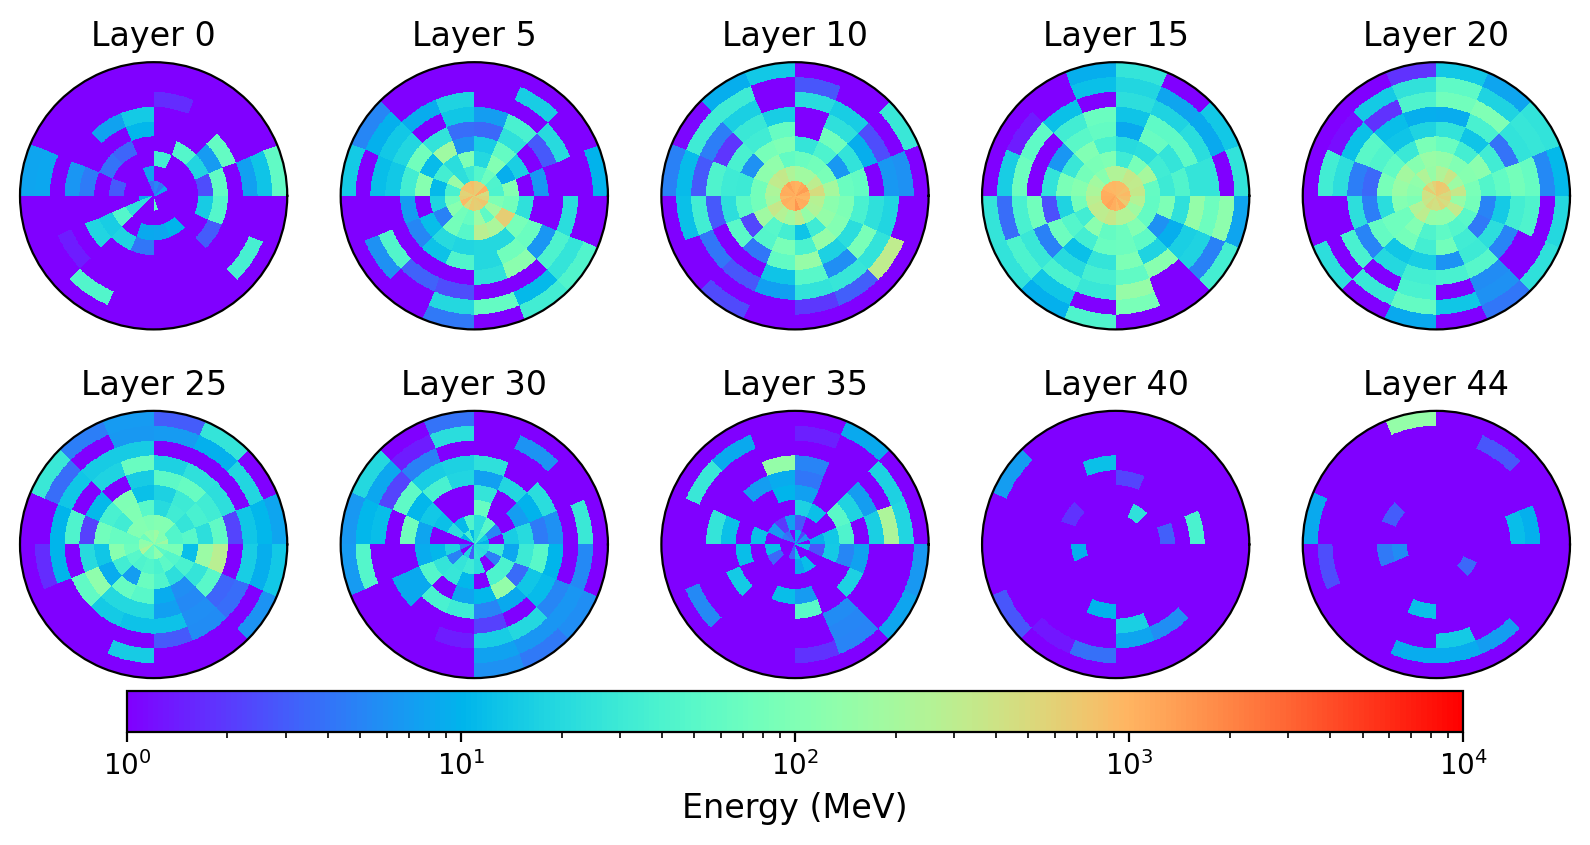

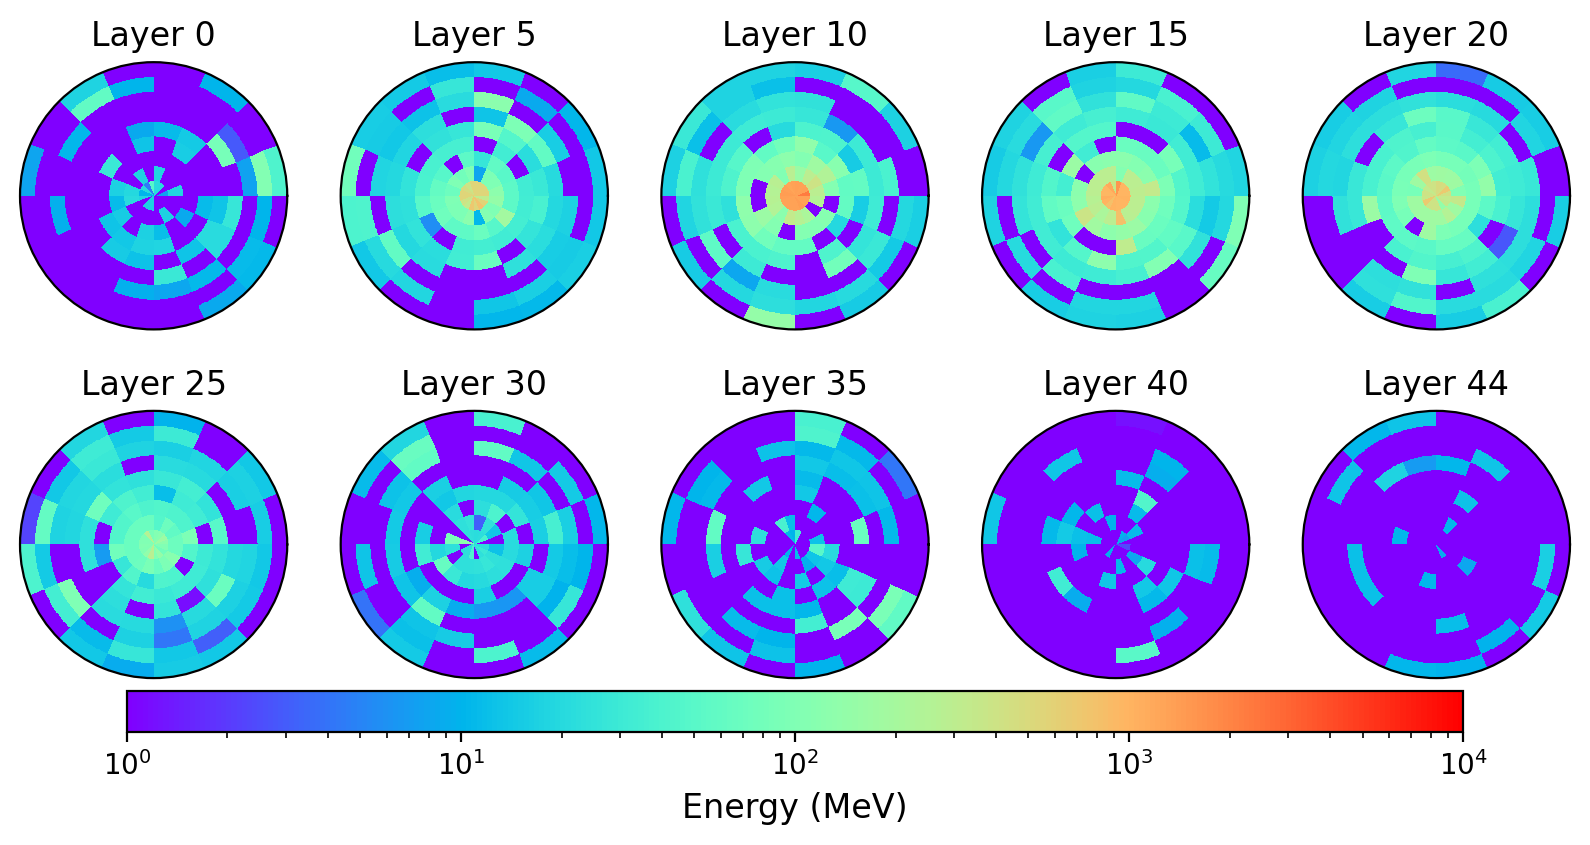

In [29]:
idx= 7000
HLF_1_electron.DrawSingleShower(xtarget_samples[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow')
HLF_1_electron.DrawSingleShower(xrecon_samples_alt[idx,:].detach().cpu().numpy(), vmax=1e+4, vmin=1e+0, cmap='rainbow') 

In [30]:
xrecon_samples_alt[7000,:]

tensor([ 7.7019, 18.5743,  0.0000,  ...,  0.0000, 16.3602,  0.0000])

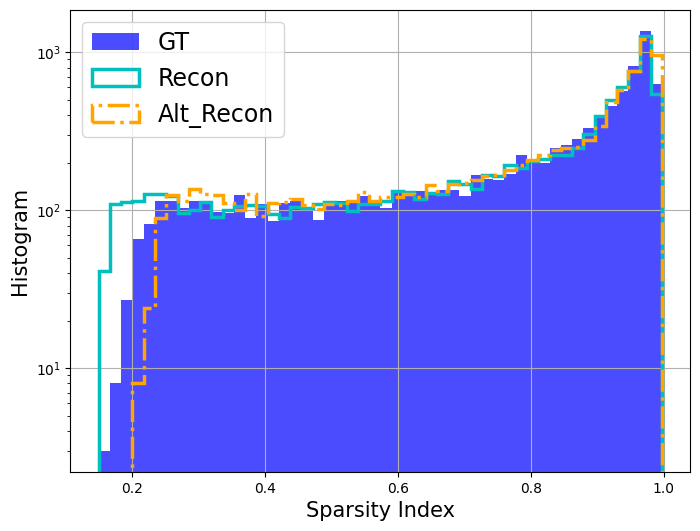

In [31]:
minVal, maxVal = min(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy()), max(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
plt.hist(((xrecon_samples_alt == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
# plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=50, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
plt.xlabel("Sparsity Index", fontsize=15)
plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Alt_Recon", "Sample /w QPU"], fontsize=17)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

<Figure size 800x600 with 0 Axes>

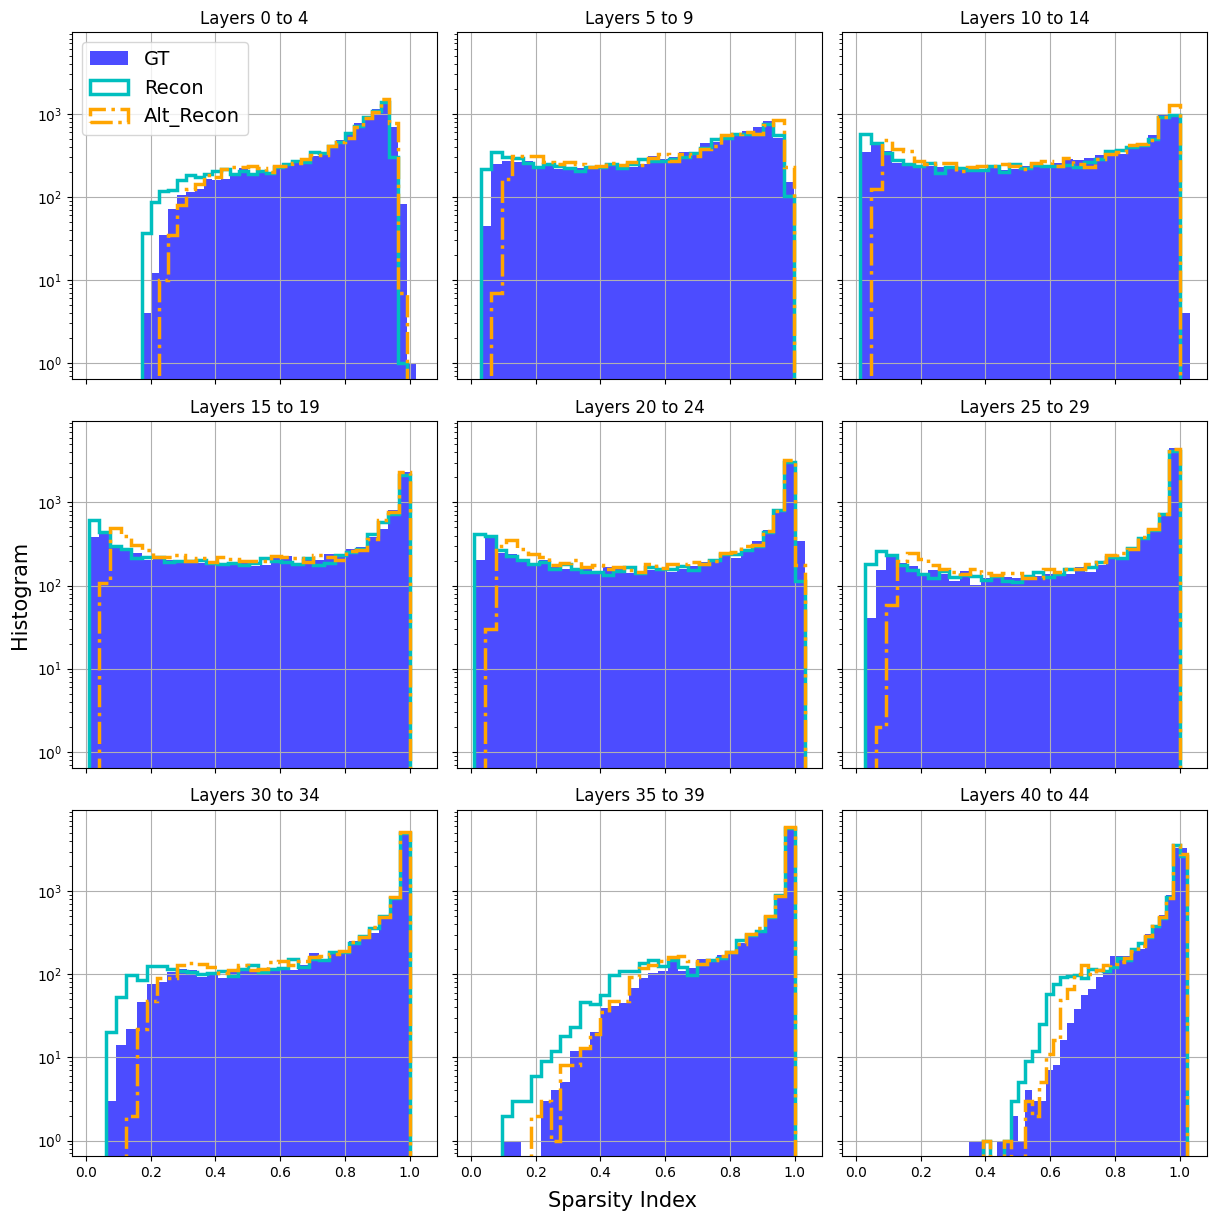

In [32]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    ax.hist(((xrecon_samples_alt[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        ax.legend(["GT", "Recon", "Alt_Recon", "Sample w/ QPU"], fontsize=14)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


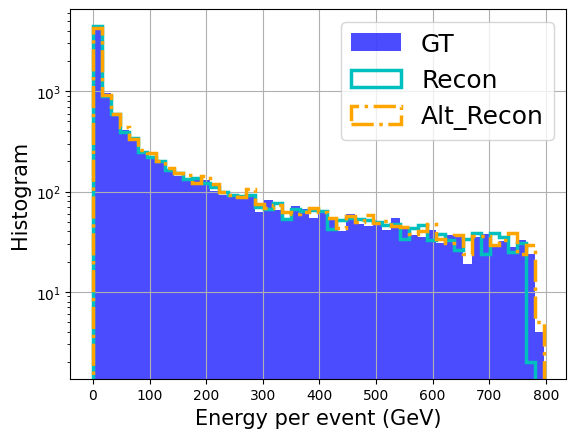

torch.Size([10000, 6480])


In [33]:
minVal, maxVal = min(xtarget_samples.sum(dim=1).numpy()/1000), max(xtarget_samples.sum(dim=1).numpy()/1000)
binwidth = (maxVal-minVal)/50
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="c")
plt.hist(xrecon_samples_alt.sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashdot")

plt.xlabel("Energy per event (GeV)", fontsize=15)

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Alt_Recon", "Sample w/ QPU"], fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

<Figure size 800x600 with 0 Axes>

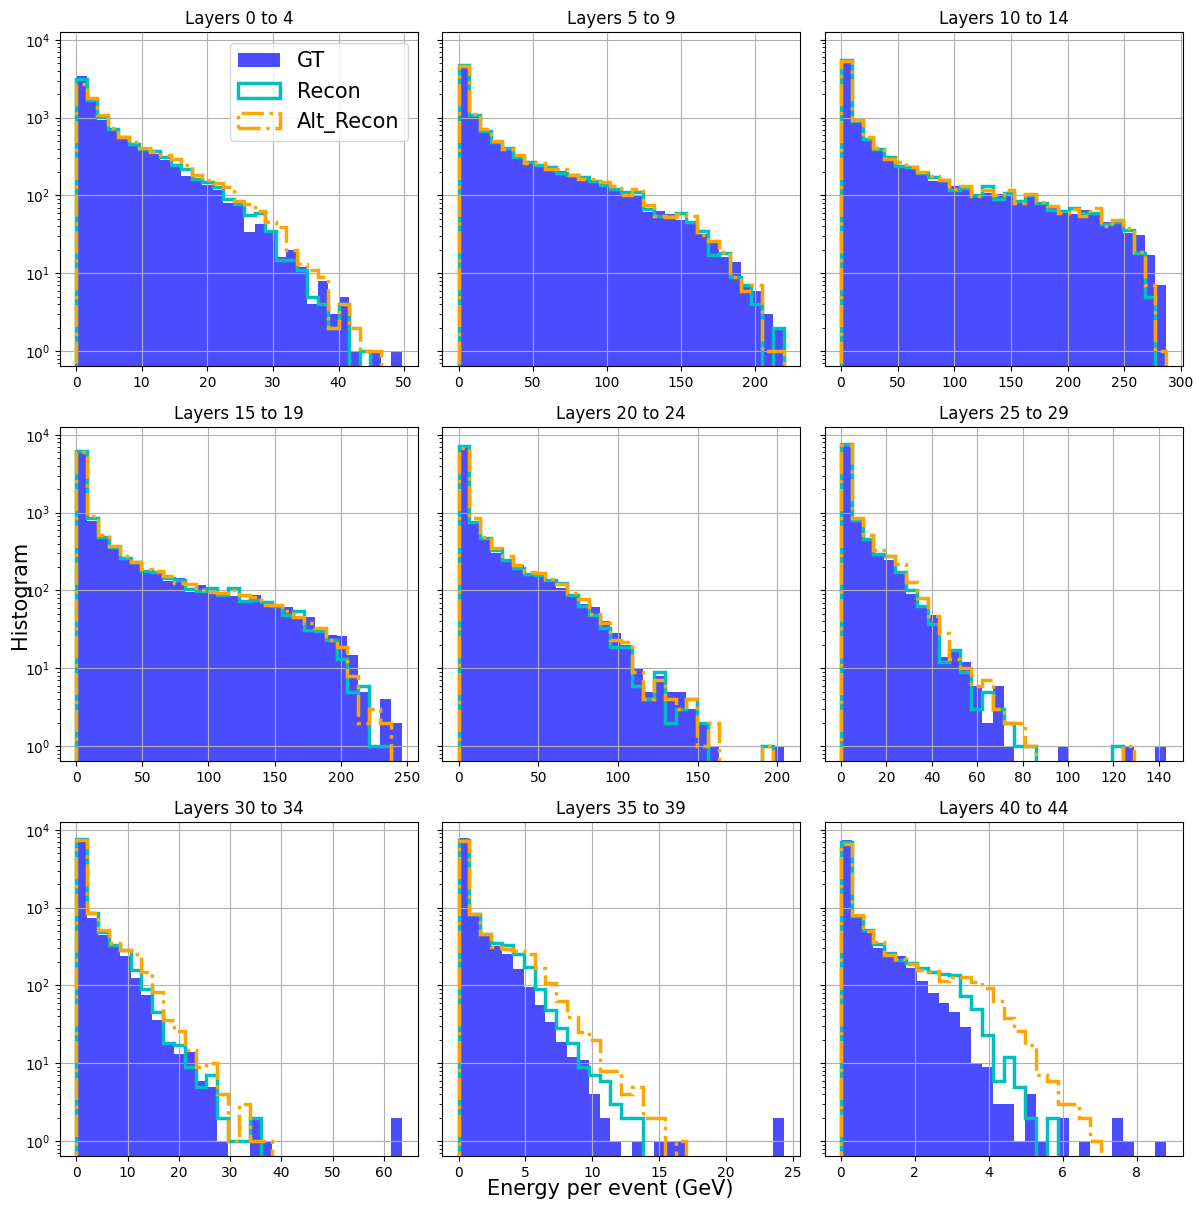

In [34]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000), max(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000)
    binwidth = (maxVal-minVal)/30
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="c")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xrecon_samples_alt[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(minVal, maxVal + binwidth, binwidth), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Alt_Recon", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

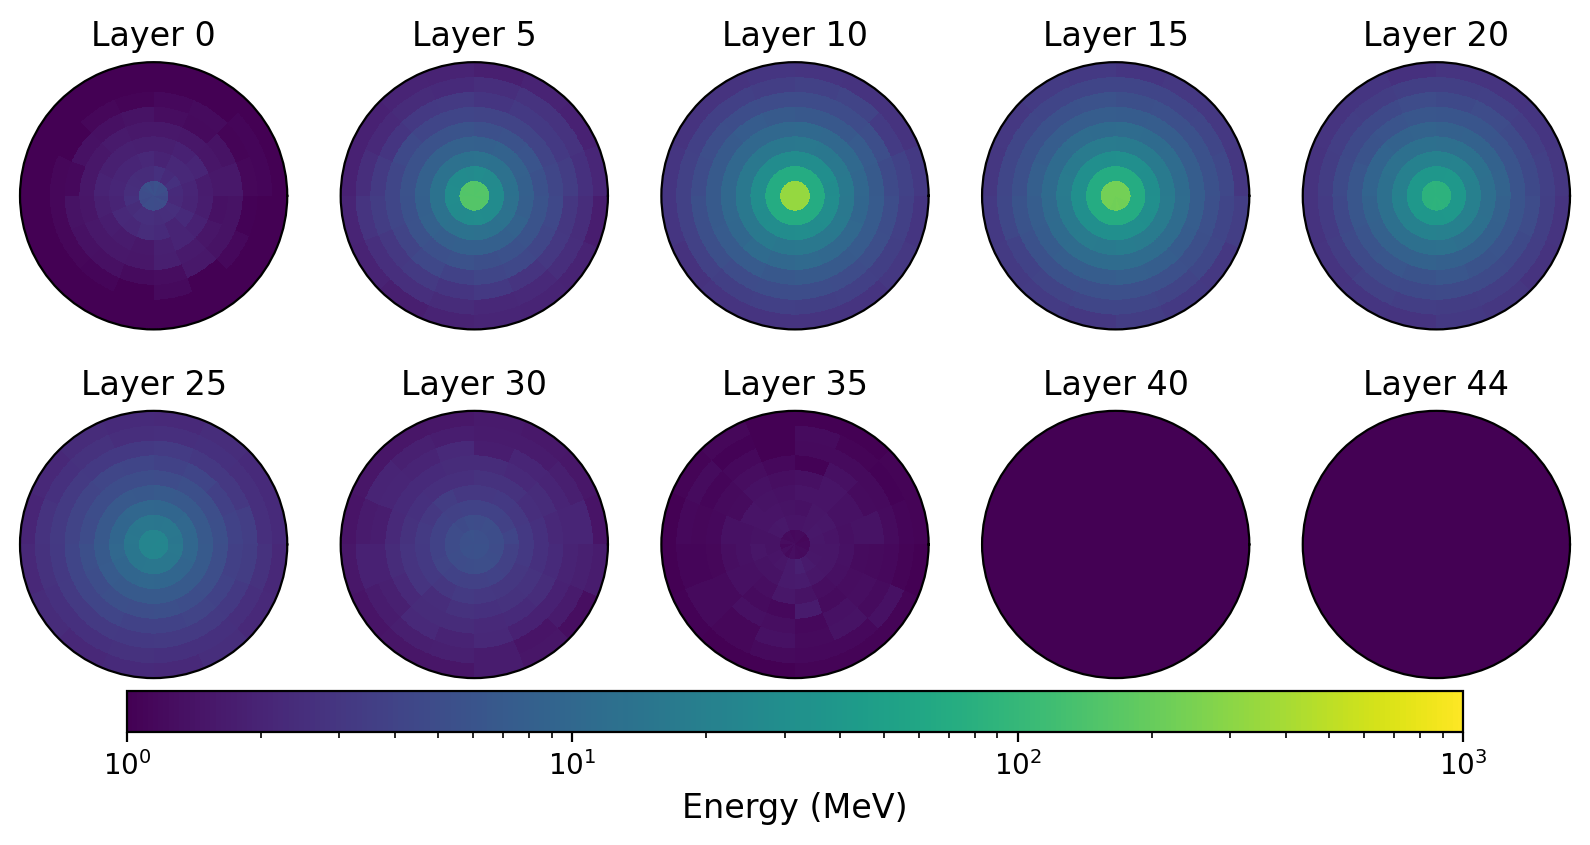

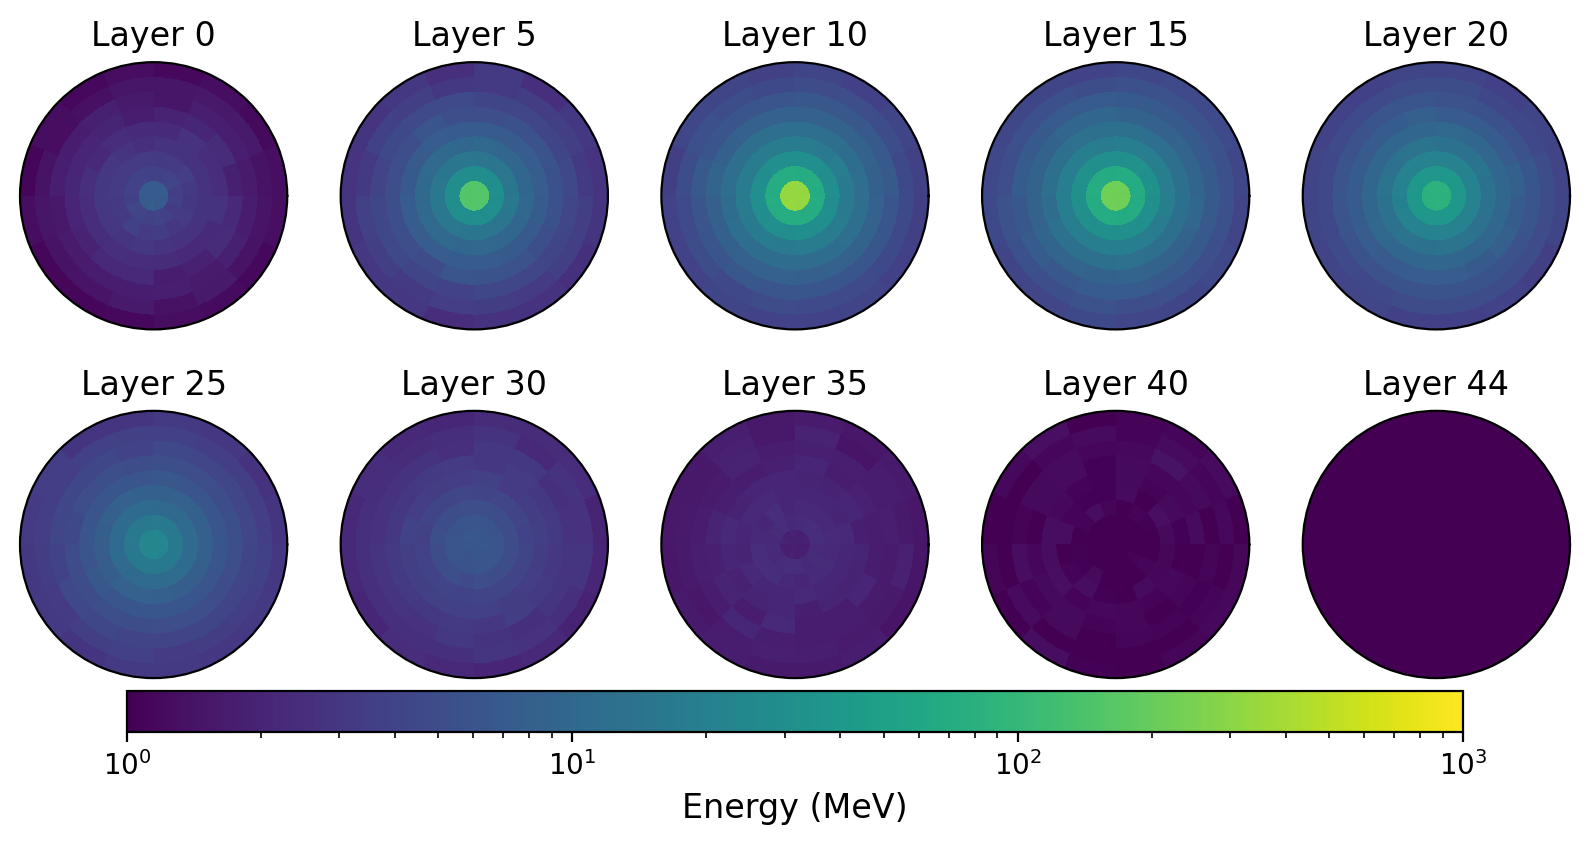

In [35]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44]
xtarget_mean = xtarget_samples.mean(dim=0)
xrecon_mean_alt = xrecon_samples_alt.mean(dim=0)
HLF_1_electron.DrawSingleShower(xtarget_mean.detach().cpu().numpy(), vmax=1e+3, vmin=1e+0)
HLF_1_electron.DrawSingleShower(xrecon_mean_alt.detach().cpu().numpy(), vmax=1e+3, vmin=1e+0)